* This notebook implements the VAE model in [Kingma (2013)](https://arxiv.org/abs/1312.6114).

## Variational Auto-encoder

### Motivation

In addition to the values of observable and of its latent variable, we are to encode the uncertainties of them also.

### Definitions

* Let $X$ be the observed random variable and $Z$ the latent random variable. Let

  \begin{equation}
    Z \sim P_{Z}
  \end{equation}

  be some given prior.
  
* And let

  \begin{equation}
    X \mid Z \sim P_{X \mid Z; \phi}
  \end{equation}

  for some distribution in a family parameterized by $\phi$.

For instance, if $X \in \mathbb{R}$, it is general to assume a multivariate Gaussian distribution, diagonalized or semi-diagonalized, then we have

\begin{equation}
  X \mid Z \sim \mathcal{N} \left( \mu(Z; \phi_1), \sigma(Z; \phi_2) \right),
\end{equation}

for some universality functions $\mu(\cdot; \phi_2)$ and $\sigma(\cdot; \phi_2)$ and $\phi := (\phi_1, \phi_2)$.

### Variational Inference

Utilization of the dataset of $x$ forces us to employ some distribution $q(z \mid x)$ (to be determined) to fit $p(z \mid x)$ (and if the dataset is of $z$, then we are forced to $p(x \mid z)$ instead), then we have the bound by KL-divergence

\begin{equation}
  \text{KL} \left( q(z \mid x) \| p(z \mid x) \right)
  = \text{KL} \left( q(z \mid x) \| p(x, z) \right) + \ln p(x)
  \geq 0.
\end{equation}

Thus, a loss

\begin{align}
  L(x)
  & := \text{KL} \left( q(z \mid x) \| p(y, z) \right) \\
  & = \mathbb{E}_{z \sim q(z \mid x)} \left[
         \ln q(z \mid x) - \ln p(x \mid z) - \ln p(z) \right] \\
  & \geq - \ln p(x).
\end{align}

The equality can be reached if and only if $q(z \mid x) = p(z \mid x)$.

### Relation with Autoencoder

* The $\mathbb{E}_{z \sim q(z \mid x)} \left[ - \ln p(x \mid z) \right]$ part can be interpreted as a reconstruction loss.

* The $\mathbb{E}_{z \sim q(z \mid x)} \left[ - \ln p(z) \right]$ part serves as regularization terms.

* It seems that the $\mathbb{E}_{z \sim q(z \mid x)} \left[ \ln q(z \mid x) \right]$ part has no correspondence in auto-encoder.

### Example

In this very example on the MNIST dataset:

\begin{align}
  Z & \sim \mathcal{N} (0, 1); \\
  X \mid Z & \sim \text{Bernoulli}\left( p(z; \theta) \right).
\end{align}

And inference distributions:

\begin{align}
  Z_0 \mid X & \sim \mathcal{N}\left( \mu(x; \phi_1), \sigma(x; \phi_2) \right); \\
  Z \mid Z_0 & \sim T(z_0).
\end{align}

where $Z_0$ obeys the "base inference distribution", as a Gaussian; and $T$ is bijective with universality.

## Implementation

In [1]:
%matplotlib inline

from IPython.display import display
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import tensorflow.contrib.distributions as tfd
from tensorflow.contrib.distributions.python.ops import bijectors as tfb
from tensorflow.examples.tutorials.mnist import input_data

# For reproducibility
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

### Functions

In [2]:
def get_p_X_z(z, X_dim, hidden_layers=None,
              name='p_X_z', reuse=None):
  """Returns the distribution of P(X|Z).
  
  X | Z ~ Bernoulli( p(Z) ).
  
  Args:
    z: Tensor of the shape `[batch_size, z_dim]`.
    X_dim: Positive integer.
    hidden_layers: List of positive integers. Defaults to
      `[128, 256, 512]`.
    
  Returns:
    An instance of `tfd.Distribution`.
  """
  if hidden_layers is None:
    hidden_layers = [128, 256, 512]
    
  with tf.variable_scope(name, reuse=reuse):
    hidden = z
    for hidden_layer in hidden_layers:
      hidden = tf.layers.dense(hidden, hidden_layer,
                               activation=tf.nn.relu)
    logits = tf.layers.dense(hidden, X_dim, activation=None)  
    
    p_X_yz = tfd.Independent(tfd.Bernoulli(logits=logits))
    return p_X_yz

In [3]:
def get_q_z_X(X, z_dim, hidden_layers=None, bijectors=None,
              dtype='float32', name='q_z_X', reuse=None):
  """Returns the distribution of Z | X.
  
  Z = bijector(Z_0), and
  Z_0 | X ~ Normal(mu(X;phi), sigma(X;phi)).
  
  Args:
    X: Tensor with shape `[batch_size, X_dim]`.
    z_dim: Positive integer.
    hidden_layers: List of positive integers. Defaults to
      `[512, 256, 128]`.
    bijectors: List of `tfb.Bijector`s. Defaults to an empty
      list.
    
  Returns:
    An instance of `tfd.Distribution`.
  """
  if bijectors is None:
    bijectors = []
  if hidden_layers is None:
    hidden_layers = [512, 256, 128]
    
  with tf.variable_scope(name, reuse=reuse):
    hidden = X
    for hidden_layer in hidden_layers:
      hidden = tf.layers.dense(hidden, hidden_layer,
                               activation=tf.nn.relu)
    # Outputs in the fiber-bundle space
    output = tf.layers.dense(hidden, z_dim * 2, activation=None)
    # shape: [batch_size, z_dim]
    mu, log_var = tf.split(output, [z_dim, z_dim], axis=1)
    
    q_z0_X = tfd.MultivariateNormalDiag(mu, tf.exp(log_var))
    chain = tfb.Chain(bijectors)
    q_z_X = tfd.TransformedDistribution(q_z0_X, chain)
    return q_z_X

In [4]:
def get_bijectors(name='bjiectors', reuse=None):
  """Complexify the inference distribution by extra-bijectors like
  normalizing flows.
  
  Returns:
    List of `Bijector`s.
  """
  with tf.variable_scope(name, reuse=reuse):
    bijectors = []
    #return bijectors  # test!
    for i in range(10):
      # Get one bijector
      shift_and_log_scale_fn = \
        tfb.masked_autoregressive_default_template([128])
      # MAP is extremely slow in training. Use IAF instead.
      bijector = tfb.Invert(
          tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn))
      bijectors.append(bijector)
    return bijectors

In [5]:
def get_loss_X(get_q_z_X, get_p_X_z, p_z=None, reuse=None):
  """L(X) := E_{z ~ q(z|X)} [ log_q(z|X) - log_p(z) - log_p(X|z) ].
  
  Args:
    get_q_z_X: Callable that returns an instance of `tfd.Distribution`,
      as the q(z|X), which takes arguments `X` and `reuse`.
    get_p_X_z: Callable that returns an instance of `tfd.Distribution`,
      as the p(X|z), which takes arguments `z`, and `reuse`.
    p_z: An instance of `tfd.Distribution`, as the p(z). Defaults to
      flatten prior.
    reuse: If reuse the variables in `get_q_z_X` and `get_p_X_z`.
    
  Returns:
    Callable that maps two tensors of the shape `[batch_size, Xdim]`
    to a scalar.
  """
  
  def loss_X(X,name='loss_X'):
    """
    Args:
      X: Tensor of the shape `[batch_size, X_dim]`.

    Returns:
      A scalar.
    """
    with tf.name_scope(name):
      # Get the distribution q(z|X)
      q_z_X = get_q_z_X(X, reuse=reuse)
      
      # Get the distribution p(X|z)
      z_samples = q_z_X.sample()
      p_X_z = get_p_X_z(z_samples, reuse=reuse)
      
      # Compute the tensor of L(X)
      loss_X_tensor = tf.zeros([batch_size])  # initialize.
      # E_{z ~ q(z|X)} [ log_q(z|X) ]
      loss_X_tensor += q_z_X.log_prob(z_samples)
      if p_z is not None:
        # E_{z ~ q(z|X)} [ - log_p(z) ]
        loss_X_tensor += -1 * p_z.log_prob(z_samples)
      # E_{z ~ q(z|X)} [ - log_p(X|z) ]
      loss_X_tensor += -1 * p_X_z.log_prob(X)
      loss_X_scalar = tf.reduce_mean(loss_X_tensor)
      return loss_X_scalar
    
  return loss_X

### Loss

In [6]:
batch_size = 128
X_dim = 28 * 28
X = tf.placeholder(shape=[batch_size, X_dim], dtype='float32', name='X')

In [7]:
z_dim = 64
p_z = tfd.MultivariateNormalDiag(tf.zeros([z_dim]), name='p_z')

In [8]:
def _get_q_z_X(X, reuse):
  bijectors = get_bijectors(reuse=reuse)
  #bijectors = []  # test!
  return get_q_z_X(X, z_dim, bijectors=bijectors, reuse=reuse)

def _get_p_X_z(z, reuse):
  return get_p_X_z(z, X_dim=X_dim, reuse=reuse)

loss_X = get_loss_X(_get_q_z_X, _get_p_X_z,
                    p_z=p_z, reuse=tf.AUTO_REUSE)
loss_X_scalar = loss_X(X)

### Generating

In [9]:
z_samples = tf.placeholder(shape=[batch_size, z_dim],
                           dtype='float32',
                           name='z_samples')
X_samples = _get_p_X_z(z_samples, reuse=tf.AUTO_REUSE).sample()

In [10]:
def get_image(array):
  """
  Args:
    array: Numpy array with shape `[28*28]`.
    
  Returns:
    An image.
  """
  array = 255 * array
  array = array.reshape([28, 28])
  array = array.astype(np.uint8)
  return Image.fromarray(array)

### Training

In [11]:
optimizer = tf.train.AdamOptimizer(epsilon=1e-3)
train_op = optimizer.minimize(loss_X_scalar)

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [13]:
mnist = input_data.read_data_sets('dat/MNIST', one_hot=True)

def get_X_y_batch():
    X_batch, y_batch = mnist.train.next_batch(batch_size)
    # Since X | Y, Z ~ Bernoulli, the observed value of X shall
    # either be 0 or 1,
    X_batch = np.where(X_batch >= 0.5, np.ones_like(X_batch),
                       np.zeros_like(X_batch))
    return X_batch, y_batch

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting dat/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting dat/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting dat/MNIST/t10k-images-idx3-ubyte.gz
Extracting dat/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


100%|██████████| 100000/100000 [13:58<00:00, 119.21it/s]


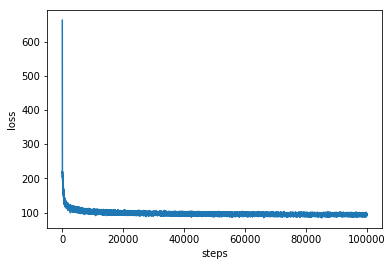

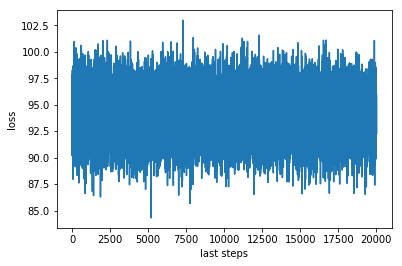

Final loss: 93.8035


In [14]:
loss_vals = []
for i in tqdm(range(100000)):
  X_batch, y_batch = mnist.train.next_batch(batch_size)
  _, loss_val = sess.run([train_op, loss_X_scalar], {X: X_batch})
  if np.isnan(loss_val):
    raise ValueError('Loss has been NaN.')
  loss_vals.append(loss_val)
  
# Visualization
plt.plot(loss_vals)
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()

# Zoomed in
last_steps = 20000
plt.plot(loss_vals[-last_steps:])
plt.xlabel('last steps')
plt.ylabel('loss')
plt.show()

print('Final loss:', np.mean(loss_vals[-100:]))

In [15]:
z_sample_vals = np.random.normal(size=[batch_size, z_dim])
X_sample_vals = sess.run(X_samples, {z_samples: z_sample_vals})

# Display the results
n_display = 5
for i in range(n_display):
  print('Gnerated:')
  display(get_image(X_sample_vals[i]))
  print()

Gnerated:



Gnerated:



Gnerated:



Gnerated:



Gnerated:


### Effect of Normalizing-flow

* While not employing normalizing flow, 100000 iterations give the final loss about 97.8.
* With 10 normalizing flows, 100000 iterations give the final loss 93.5 (improved 4.3).

In [16]:
np.exp(4)

54.598150033144236